Until now we only created models which gets 1D input.  
So let's start to do real computer vision.

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 128
learning_rate = 0.001

We use MNIST again but this time we will use it as 2D images instead of 1D vectors.
Also we will use a validation set which you should do in your term projects too.

In [3]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False, 
                                          transform=transforms.ToTensor())

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=val_set,
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)
print(f"Train size: {len(train_set)}, Validation size: {len(val_set)}, Test size: {len(test_dataset)}")

Train size: 50000, Validation size: 10000, Test size: 10000


Always visualize your dataset to be sure about your input and output.

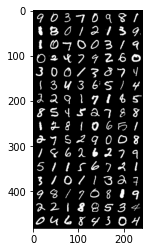

tensor([9, 0, 3, 7, 0, 9, 8, 1, 1, 8, 0, 1, 2, 1, 3, 9, 1, 0, 7, 0, 0, 3, 1, 9,
        0, 2, 4, 7, 9, 2, 6, 0, 3, 0, 0, 1, 3, 8, 7, 4, 1, 3, 4, 3, 6, 5, 1, 4,
        2, 2, 9, 1, 7, 1, 8, 5, 8, 5, 4, 5, 2, 7, 8, 8, 1, 2, 8, 1, 0, 6, 5, 1,
        2, 7, 5, 2, 9, 0, 0, 8, 1, 8, 6, 2, 6, 2, 7, 9, 5, 1, 1, 5, 6, 7, 2, 1,
        3, 1, 0, 1, 1, 3, 2, 7, 9, 8, 1, 7, 0, 8, 1, 9, 2, 2, 1, 8, 8, 5, 3, 4,
        0, 4, 6, 8, 4, 3, 0, 4])


In [4]:
# When iteration starts, queue and thread start to load data from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

import matplotlib.pyplot as plt
import numpy as np

grid_imgs = torchvision.utils.make_grid(images)
npimg = grid_imgs.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
print(labels)

In [5]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)

        return out

After this point everything is same with before.  
Only our input data dimension changed so model, loss and loaders change. Rest is the same as 1D case.

In [6]:
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    # At each epoch we perform validation to see whether our model overfit the data or not
    # We shouldn't learn anything from validation data so it looks like we are testing
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Validation Accuracy of the model on the 10000 validation images: {100 * correct / total} ")

Epoch [1/5], Step [100/391], Loss: 0.1981
Epoch [1/5], Step [200/391], Loss: 0.0929
Epoch [1/5], Step [300/391], Loss: 0.0864
Validation Accuracy of the model on the 10000 validation images: 97.85 
Epoch [2/5], Step [100/391], Loss: 0.0443
Epoch [2/5], Step [200/391], Loss: 0.0473
Epoch [2/5], Step [300/391], Loss: 0.0650
Validation Accuracy of the model on the 10000 validation images: 98.31 
Epoch [3/5], Step [100/391], Loss: 0.0074
Epoch [3/5], Step [200/391], Loss: 0.0507
Epoch [3/5], Step [300/391], Loss: 0.0487
Validation Accuracy of the model on the 10000 validation images: 98.63 
Epoch [4/5], Step [100/391], Loss: 0.0482
Epoch [4/5], Step [200/391], Loss: 0.0392
Epoch [4/5], Step [300/391], Loss: 0.0383
Validation Accuracy of the model on the 10000 validation images: 98.73 
Epoch [5/5], Step [100/391], Loss: 0.0343
Epoch [5/5], Step [200/391], Loss: 0.0241
Epoch [5/5], Step [300/391], Loss: 0.0510
Validation Accuracy of the model on the 10000 validation images: 98.82 


In [7]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy of the model on the 10000 test images: {100 * correct / total} ")

Test Accuracy of the model on the 10000 test images: 98.71 


## Residual Networks (ResNet)

So until now we built basic networks.  
Let's see how we can build more complex networks like ResNet.
To create these complex networks you need a good modularization. It helps you to both debug it easily and write it beautifully.

We first create a 3x3 convolution layer to not use the same long function definition over and over again.

<img src="img/resnet.png" width="800" height="400">

ResNet-34 (from K. He et al. “Deep Residual Learning”)!



In [8]:
# 3x3 convolution
# Takes input, output channels and stride
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=True)

Then we create the main block of the ResNet. This block will be used over and over again inside the network.


In [9]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

Now we create our model using this Residual Block

In [10]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

We are creating a smaller one for CIFAR-10 but by changing layer list below you can increase the size of the network. So modularization makes your life easier.

In [11]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
print(model)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1,

In [12]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

train_set, val_set = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.9), int(len(train_dataset)*0.1)])


# Data loader
train_loader = torch.utils.data.DataLoader(dataset= train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset= val_set,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset= test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f"Train size: {len(train_set)}, Validation size: {len(val_set)}, Test size: {len(test_dataset)}")

Files already downloaded and verified
Train size: 45000, Validation size: 5000, Test size: 10000


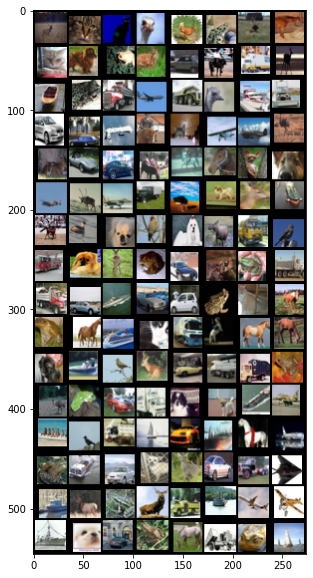

tensor([4, 3, 3, 2, 2, 6, 4, 7, 3, 5, 6, 4, 1, 7, 9, 4, 8, 6, 9, 0, 9, 2, 8, 8,
        1, 1, 0, 7, 3, 0, 0, 2, 4, 1, 1, 4, 7, 7, 5, 5, 0, 4, 0, 9, 2, 5, 4, 8,
        7, 2, 5, 2, 5, 4, 9, 2, 9, 5, 4, 6, 1, 6, 6, 9, 9, 1, 8, 1, 1, 6, 3, 7,
        6, 7, 8, 3, 9, 7, 7, 4, 5, 8, 2, 4, 1, 9, 9, 6, 2, 6, 1, 9, 5, 5, 8, 0,
        8, 2, 9, 8, 1, 8, 7, 0, 6, 8, 1, 5, 4, 1, 9, 0, 8, 4, 6, 4, 9, 8, 0, 0,
        8, 5, 1, 6, 7, 9, 6, 8])


In [13]:
# When iteration starts, queue and thread start to load data from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

grid_imgs = torchvision.utils.make_grid(images)
npimg = grid_imgs.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
print(labels)

We use the same training and testing loop

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    
    # At each epoch we perform validation to see whether our model overfit the data or not
    # We shouldn't learn anything from validation data so it looks like we are testing
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Validation Accuracy of the model on the 10000 validation images: {100 * correct / total} ")
        
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy of the model on the 10000 test images: {100 * correct / total} ")

Epoch [1/5], Step [100/352] Loss: 1.5067
Epoch [1/5], Step [200/352] Loss: 1.3439
Epoch [1/5], Step [300/352] Loss: 1.2568
Validation Accuracy of the model on the 10000 validation images: 56.42 
Epoch [2/5], Step [100/352] Loss: 0.9534
Epoch [2/5], Step [200/352] Loss: 1.0948
Epoch [2/5], Step [300/352] Loss: 1.0276
Validation Accuracy of the model on the 10000 validation images: 64.28 
Epoch [3/5], Step [100/352] Loss: 1.0015
Epoch [3/5], Step [200/352] Loss: 0.8006
Epoch [3/5], Step [300/352] Loss: 0.9781
Validation Accuracy of the model on the 10000 validation images: 69.94 
Epoch [4/5], Step [100/352] Loss: 0.9691
Epoch [4/5], Step [200/352] Loss: 0.7513
Epoch [4/5], Step [300/352] Loss: 0.6905
Validation Accuracy of the model on the 10000 validation images: 72.34 
Epoch [5/5], Step [100/352] Loss: 0.7983
Epoch [5/5], Step [200/352] Loss: 0.6524
Epoch [5/5], Step [300/352] Loss: 0.6269
Validation Accuracy of the model on the 10000 validation images: 73.72 
Test Accuracy of the mode

In [15]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')